<a href="https://colab.research.google.com/github/mohannashahrad/Borealis_AI_Plant_Tree_Project/blob/main/predictions/TreeLoss_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [37]:
# Import all the required libraries
from funcs import *
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import seaborn as sns


#Loading the Dataset

In [38]:
# Loading DataSet
data_df = load_DF('https://raw.githubusercontent.com/mohannashahrad/Borealis_AI_Plant_Tree_Project/main/Final_Data/final_data2.csv')
data_df = data_df.iloc[: , 1:]
display(data_df)

pred_df = load_DF('https://raw.githubusercontent.com/mohannashahrad/Borealis_AI_Plant_Tree_Project/main/predictions/prediction_data.csv')
pred_df = pred_df.iloc[: , 1:]
display(pred_df)


,Time,Country Name,Land Area (m2),Agriculture Land (m2),Forest Land (m2),Population,Pop Growth (%),Urban Pop (%),GDP (US$),GDP Growth (%),Forest Rents (% GDP),Coal Rents (% GDP),Oil Rents (% GDP),CO2 Emission (kt),GHG Emision (CO2 eqv),Tree Loss (ha)
0,2001,Afghanistan,652860.0,377530.0,12084.4,21606992.0,3.902805,22.169,NaN,NaN,NaN,NaN,NaN,810.0,13490.0,88.092712
1,2002,Afghanistan,652860.0,377530.0,12084.4,22600774.0,4.496719,22.261,4.055180e+09,NaN,0.958004,0.004341,0.029101,1100.0,16090.0,178.640364
2,2003,Afghanistan,652860.0,379100.0,12084.4,23680871.0,4.668344,22.353,4.515559e+09,8.832278,0.664331,0.007422,0.026686,1350.0,16780.0,244.336255
3,2004,Afghanistan,652860.0,379110.0,12084.4,24726689.0,4.321560,22.500,5.226779e+09,1.414118,0.387787,0.016455,0.025399,1130.0,16520.0,201.444959
4,2005,Afghanistan,652860.0,379100.0,12084.4,25654274.0,3.682700,22.703,6.209138e+09,11.229715,0.332205,0.010904,0.025973,1640.0,17400.0,235.956834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5634,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.499655
5635,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.572059
5636,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.164427
5637,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,970.789805


,Country Name,Time,Land Area (m2),Agriculture Land (m2),Forest Land (m2),Population,Pop Growth (%),Urban Pop (%),GDP (US$),GDP Growth (%),Forest Rents (% GDP),Coal Rents (% GDP),Oil Rents (% GDP),CO2 Emission (kt),GHG Emision (CO2 eqv)
0,Afghanistan,2021,652860.0,379190.000016,12084.4,3.984142e+07,2.143968,26.256,2.466502e+10,4.086870,0.168859,0.462267,-0.009917,11412.44990,120022.74700
1,Afghanistan,2022,652860.0,379280.000015,12084.4,4.071724e+07,2.091798,26.501,2.466502e+10,1.699511,0.166318,0.495443,-0.003917,12229.24748,125833.09580
2,Afghanistan,2023,652860.0,379280.000008,12084.4,4.158707e+07,2.030099,26.760,2.466502e+10,-0.661311,0.154180,0.527653,0.002570,13032.03860,131551.71050
3,Afghanistan,2024,652860.0,379280.000019,12084.4,4.247365e+07,1.958835,27.032,2.466502e+10,-2.993376,0.132440,0.558890,0.009535,13820.50873,137178.89980
4,Afghanistan,2025,652860.0,379280.000018,12084.4,4.338674e+07,1.782906,27.262,2.466502e+10,1.951676,0.093318,0.565317,-0.015641,13604.22368,144061.79660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,Zimbabwe,2026,386850.0,161444.574809,171681.6,1.610399e+07,2.389842,32.101,2.770215e+10,9.290227,1.269398,-0.364973,0.000000,11664.55563,31697.04787
2796,Zimbabwe,2027,386850.0,161587.831316,171220.9,1.631065e+07,2.442171,32.102,2.794775e+10,7.091720,1.756264,-0.078878,0.000000,11423.02150,31495.90483
2797,Zimbabwe,2028,386850.0,161936.265034,170760.2,1.652810e+07,2.495643,32.134,2.819250e+10,4.898133,2.275813,0.223195,0.000000,11106.58917,31157.94451
2798,Zimbabwe,2029,386850.0,161349.440084,170299.5,1.673437e+07,2.663003,32.075,3.128797e+10,13.528482,0.245408,-1.056603,0.000000,11988.65667,32493.81626


#Preprocessing 

This section consists of data normalization and one-hot encoding for discrete features.

In [39]:
discrete_cols = ['Country Name']
scale_cols = ['Land Area (m2)', 'Agriculture Land (m2)', 'Forest Land (m2)', 'Population', 'Pop Growth (%)', 'Urban Pop (%)',
                'GDP (US$)', 'GDP Growth (%)', 'Forest Rents (% GDP)', 'Coal Rents (% GDP)', 'Oil Rents (% GDP)', 'CO2 Emission (kt)',
                'GHG Emision (CO2 eqv)']

In [66]:
data_df = data_df[~data_df.isin([np.nan, np.inf, -np.inf]).any(1)]
display(data_df)
pred_df = pred_df[~pred_df.isin([0, np.nan, np.inf, -np.inf]).any(1)]
data_df = data_df[data_df['Country Name'].isin(pred_df['Country Name'])]
pred_df = pred_df[pred_df['Country Name'].isin(data_df['Country Name'])]
data_df.reset_index(inplace=True, drop=True)
pred_df.reset_index(inplace=True, drop=True)

x = data_df.loc[:, data_df.columns != 'Tree Loss (ha)'].append(pred_df);
x = standardize(x,scale_cols)
country_names = x['Country Name']
x = oneHotEncode(x,discrete_cols)
display(x)
display(pred_df)

,Time,Country Name,Land Area (m2),Agriculture Land (m2),Forest Land (m2),Population,Pop Growth (%),Urban Pop (%),GDP (US$),GDP Growth (%),Forest Rents (% GDP),Coal Rents (% GDP),Oil Rents (% GDP),CO2 Emission (kt),GHG Emision (CO2 eqv),Tree Loss (ha)
0,2003,Afghanistan,652860.0,379100.0,12084.4,23680871.0,4.668344,22.353,4.515559e+09,8.832278,0.664331,0.007422,0.026686,1350.0,16780.0,244.336255
1,2004,Afghanistan,652860.0,379110.0,12084.4,24726689.0,4.321560,22.500,5.226779e+09,1.414118,0.387787,0.016455,0.025399,1130.0,16520.0,201.444959
2,2005,Afghanistan,652860.0,379100.0,12084.4,25654274.0,3.682700,22.703,6.209138e+09,11.229715,0.332205,0.010904,0.025973,1640.0,17400.0,235.956834
3,2006,Afghanistan,652860.0,379100.0,12084.4,26433058.0,2.990524,22.907,6.971286e+09,5.357403,0.454077,0.011152,0.022144,1940.0,21040.0,152.084536
4,2007,Afghanistan,652860.0,379100.0,12084.4,27100542.0,2.493830,23.113,9.747880e+09,13.826320,0.342749,0.076415,0.014696,2360.0,24880.0,252.841662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,2014,Vietnam,310070.0,108737.0,139271.0,91713850.0,1.053636,33.115,1.862047e+11,5.983655,2.278192,0.481275,3.656085,168560.0,283000.0,217341.529400
989,2015,Vietnam,310070.0,121478.0,140618.6,92677082.0,1.044781,33.809,1.932411e+11,6.679289,1.707829,0.259125,1.491286,209200.0,327320.0,217883.209600
990,2016,Vietnam,310070.0,121722.0,143776.8,93640435.0,1.034107,34.510,2.052762e+11,6.210812,1.534306,0.255078,1.052861,223870.0,341580.0,353446.020700
991,2017,Vietnam,310070.0,121688.0,144153.9,94600643.0,1.020199,35.213,2.237799e+11,6.812246,1.887379,0.308382,1.287539,222130.0,340420.0,286940.292200


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Time,Land Area (m2),Agriculture Land (m2),Forest Land (m2),Population,Pop Growth (%),Urban Pop (%),GDP (US$),GDP Growth (%),Forest Rents (% GDP),Coal Rents (% GDP),Oil Rents (% GDP),CO2 Emission (kt),GHG Emision (CO2 eqv),Country Name_Afghanistan,Country Name_Albania,Country Name_Argentina,Country Name_Australia,Country Name_Austria,Country Name_Bangladesh,Country Name_Brazil,Country Name_Bulgaria,Country Name_Canada,Country Name_Chile,Country Name_China,Country Name_Colombia,Country Name_Czech Republic,"Country Name_Egypt, Arab Rep.",Country Name_France,Country Name_Georgia,Country Name_Germany,Country Name_Greece,Country Name_Hungary,Country Name_India,Country Name_Indonesia,"Country Name_Iran, Islamic Rep.",Country Name_Italy,Country Name_Japan,Country Name_Kazakhstan,"Country Name_Korea, Rep.",Country Name_Kyrgyz Republic,Country Name_Malaysia,Country Name_Mexico,Country Name_Mongolia,Country Name_Morocco,Country Name_Mozambique,Country Name_Myanmar,Country Name_New Zealand,Country Name_Niger,Country Name_Nigeria,Country Name_Norway,Country Name_Pakistan,Country Name_Peru,Country Name_Philippines,Country Name_Poland,Country Name_Romania,Country Name_Russian Federation,Country Name_Serbia,Country Name_Slovak Republic,Country Name_Slovenia,Country Name_South Africa,Country Name_Spain,Country Name_Tajikistan,Country Name_Thailand,Country Name_Turkey,Country Name_Ukraine,Country Name_United Kingdom,Country Name_United States,Country Name_Uzbekistan,"Country Name_Venezuela, RB",Country Name_Vietnam
0,2003,-0.462027,-0.239112,-0.522858,-0.327214,3.975764,-2.234643,-0.433586,1.698954,0.126495,-0.288449,-0.447869,-0.356877,-0.415699,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2004,-0.462027,-0.239102,-0.522858,-0.322804,3.607177,-2.226931,-0.433352,-0.245592,-0.074947,-0.282280,-0.448183,-0.357023,-0.415860,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2005,-0.462027,-0.239112,-0.522858,-0.318893,2.928153,-2.216281,-0.433030,2.327401,-0.115434,-0.286071,-0.448043,-0.356684,-0.415313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2006,-0.462027,-0.239112,-0.522858,-0.315609,2.192460,-2.205578,-0.432781,0.788074,-0.026659,-0.285901,-0.448979,-0.356484,-0.413047,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2007,-0.462027,-0.239112,-0.522858,-0.312794,1.664539,-2.194770,-0.431870,3.008057,-0.107754,-0.241328,-0.450799,-0.356205,-0.410657,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708,2026,-0.556833,-0.472798,-0.433659,0.007002,0.113788,-1.225952,-0.316404,0.824901,1.026003,-0.070865,-0.760308,-0.145279,-0.114627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1709,2027

,Country Name,Time,Land Area (m2),Agriculture Land (m2),Forest Land (m2),Population,Pop Growth (%),Urban Pop (%),GDP (US$),GDP Growth (%),Forest Rents (% GDP),Coal Rents (% GDP),Oil Rents (% GDP),CO2 Emission (kt),GHG Emision (CO2 eqv)
0,Afghanistan,2021,652860.0,379190.000016,12084.4,3.984142e+07,2.143968,26.256,2.466502e+10,4.086870,0.168859,0.462267,-0.009917,11412.44990,120022.7470
1,Afghanistan,2022,652860.0,379280.000015,12084.4,4.071724e+07,2.091798,26.501,2.466502e+10,1.699511,0.166318,0.495443,-0.003917,12229.24748,125833.0958
2,Afghanistan,2023,652860.0,379280.000008,12084.4,4.158707e+07,2.030099,26.760,2.466502e+10,-0.661311,0.154180,0.527653,0.002570,13032.03860,131551.7105
3,Afghanistan,2024,652860.0,379280.000019,12084.4,4.247365e+07,1.958835,27.032,2.466502e+10,-2.993376,0.132440,0.558890,0.009535,13820.50873,137178.8998
4,Afghanistan,2025,652860.0,379280.000018,12084.4,4.338674e+07,1.782906,27.262,2.466502e+10,1.951676,0.093318,0.565317,-0.015641,13604.22368,144061.7966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,Vietnam,2026,310070.0,142063.092387,150221.1,1.029423e+08,1.034808,41.579,3.620000e+11,5.497894,1.899199,0.326000,-1.251625,319632.57770,500498.9321
716,Vietnam,2027,310070.0,144813.643808,150980.1,1.038584e+08,1.024655,42.288,3.760000e+11,5.292533,1.957119,0.547834,-1.334665,330684.89720,518038.9416
717,Vietnam,2028,310070.0,147810.364870,151739.1,1.047349e+08,1.014946,43.000,3.920000e+11,4.996402,2.006262,0.774220,-1.406464,340157.35960,533250.6196
718,Vietnam,2029,310070.0,149112.763258,152116.2,1.056951e+08,1.056135,43.703,4.090000e+11,5.378918,1.846834,0.000929,-2.670424,350670.82760,547676.9609


# Splitting the dataset into test and train sets

In [41]:
# Splitting the dataset into training and test parts
x_train = x[x['Time'] <= 2020]
x_test = x[x['Time'] > 2020]
y_train = data_df['Tree Loss (ha)']
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(993, 71)
(720, 71)
(993,)


# XGBoost

In [42]:
dtrain = xgb.DMatrix(data=x_train,label=y_train)
params = {
    'gamma':0,                 
    'learning_rate':0.07,
    'max_depth':5,
    'min_child_weight':1.5,
    'n_estimators':1000,                                                                    
    'reg_alpha':0.75,
    'reg_lambda':0.45,
    'subsample':0.6,
    'seed':42
}
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=999,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,270021.637500,7304.687598,269951.671875,27991.978600
1,252000.468750,6316.179750,251873.490625,25130.352937
2,235624.440625,5576.887469,235437.781250,22218.634467
3,220464.106250,5093.920610,220075.312500,19549.335278
4,206409.890625,4694.774433,205902.237500,17094.347290
...,...,...,...,...
119,21181.915234,819.107096,67448.953907,11046.501695
120,21101.572266,803.578441,67449.666406,11040.225674
121,20980.126562,792.943614,67357.704688,10952.386883
122,20867.385547,786.919712,67287.770312,11007.386527


#Hyper parameter Tuning for XGBoost

In [43]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(4,10)
    for min_child_weight in range(1,8)
]

min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=4, min_child_weight=1
	MAE 65380.088281 for 293 rounds
CV with max_depth=4, min_child_weight=2
	MAE 66783.296875 for 334 rounds
CV with max_depth=4, min_child_weight=3
	MAE 66890.9476564 for 223 rounds
CV with max_depth=4, min_child_weight=4
	MAE 72460.9515624 for 101 rounds
CV with max_depth=4, min_child_weight=5
	MAE 71837.8921876 for 120 rounds
CV with max_depth=4, min_child_weight=6
	MAE 71140.1414062 for 120 rounds
CV with max_depth=4, min_child_weight=7
	MAE 73457.585156 for 101 rounds
CV with max_depth=5, min_child_weight=1
	MAE 64685.3187498 for 236 rounds
CV with max_depth=5, min_child_weight=2
	MAE 67215.428125 for 123 rounds
CV with max_depth=5, min_child_weight=3
	MAE 66444.82578099999 for 95 rounds
CV with max_depth=5, min_child_weight=4
	MAE 71129.0390622 for 63 rounds
CV with max_depth=5, min_child_weight=5
	MAE 72079.9851562 for 63 rounds
CV with max_depth=5, min_child_weight=6
	MAE 71075.0765624 for 63 rounds
CV with max_depth=5, min_child_weight=7
	M

In [44]:
data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)
xg_reg = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=8,
                 min_child_weight=3,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
xg_reg.fit(x_train,y_train)

[05:18:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4, learning_rate=0.07, max_depth=8,
             min_child_weight=3, n_estimators=1000, reg_alpha=0.75,
             reg_lambda=0.45, seed=42, subsample=0.6)

#Feature Importance using XGBoost

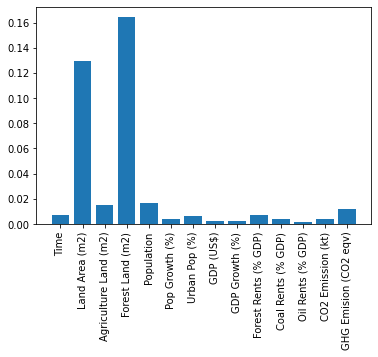

In [48]:
plt.bar(range(14), xg_reg.feature_importances_[:14])
LABELS = x_train.columns[:14]
plt.xticks(range(len(xg_reg.feature_importances_[:14])), LABELS, rotation='vertical')
plt.show()

 # Prediction

In [71]:
y_test = xg_reg.predict(x)
y_pred = pd.DataFrame(data=y_test, columns=['Deforestation Rate'])
y_pred['Time'] = x['Time']
y_pred["Country Name"] = country_names
y_pred.to_csv('deforestation_rate')